In [2]:
import pandas as pd
import numpy as np


path = "./data/complete_dataset.csv"
df = pd.read_csv(path)
# df = df[df['DATE'].between(20160130, 20161231, inclusive='neither')]  # 20161231

In [3]:
df = df[df['DATE'].between(19570101, 20161231, inclusive='both')]
header = list(df.columns.values)
print(header)

['permno', 'DATE', 'mvel1', 'RET', 'prc', 'SHROUT', 'beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'indmom', 'mom1m', 'mom6m', 'mom12m', 'mom36m', 'mve0', 'pricedelay', 'turn', 'absacc', 'acc', 'age', 'agr', 'cashdebt', 'cashpr', 'cfp', 'cfp_ia', 'chatoia', 'chcsho', 'chempia', 'chinv', 'chpmia', 'convind', 'currat', 'depr', 'divi', 'divo', 'dy', 'egr', 'ep', 'gma', 'grcapx', 'grltnoa', 'herf', 'hire', 'invest', 'lev', 'lgr', 'mve_ia', 'operprof', 'orgcap', 'pchcapx_ia', 'pchcurrat', 'pchdepr', 'pchgm_pchsale', 'pchquick', 'pchsale_pchinvt', 'pchsale_pchrect', 'pchsale_pchxsga', 'pchsaleinv', 'pctacc', 'ps', 'quick', 'rd', 'rd_mve', 'rd_sale', 'realestate', 'roic', 'salecash', 'saleinv', 'salerec', 'secured', 'securedind', 'sgr', 'sin', 'sp', 'tang', 'tb', 'aeavol', 'cash', 'chtx', 'cinvest', 'ear', 'nincr', 'roaq', 'roavol', 'roeq', 'rsup', 'stdacc', 'stdcf', 'ms', 'baspread', 'ill', 'maxret', 'retvol', 'std_dolvol', 'std_turn', 'zerotrade', 'sic2', 'bm', 'bm_ia', 'b/m', 'tbl', 'ntis

### Data Preprocessing

In [4]:
# function for data preprocessing
def getDataset(year_begin, year_num):
    date_begin = year_begin * 1e4 + 101
    date_end  = (year_begin+year_num-1) *1e4 +1231
    dataset  = df[df['DATE'].between(date_begin, date_end, inclusive='both')].values
    
    idx_mve0 = header.index("mve0")
    idx_sic2 = header.index("sic2")
    idx_bm = header.index("b/m")
    cht_index = list(range(6, idx_bm))  
    cht_index.remove(idx_mve0)
    cht_index.remove(idx_sic2)
    cht_index.insert(0, 2)

    dataset_size = dataset.shape[0]
    sic2 = np.zeros([dataset_size, 1])
    output_data = np.zeros([dataset_size, 1])
    pred_data = np.ones([dataset_size, 9])
    input_data = np.zeros([dataset_size, 920])
    sic2_list = [1, 2, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25,
                26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44,
                45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
                63, 64, 65, 67, 70, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87,
                89, 99]

    # complete the missing data for characteristics
    # 1. complete the non-monthly updated items(already done from the data source)
    # 2. complete no data items
    first_flag = True
    year = year_begin
    tidx_list = []
    for i in range(year_num): # year
        month = 1
        for j in range(12): # month
            date_begin = int(year*1e4 + month*1e2 + 0)
            date_end = int(year*1e4 + month*1e2 + 32)
            df_process = df[df['DATE'].between(date_begin, date_end, inclusive='both')]
            df_process_np = df_process.values
            
            for col in cht_index:
                single_col = df_process_np[:,col]
                if np.isnan(single_col).all():
                    mid = 0
                    df_process_np[:,col] = mid
                elif np.isnan(single_col).any():
                    mid = np.median(single_col[~np.isnan(single_col)])
                    df_process_np[np.isnan(single_col),col] = mid
                else:
                    continue
            
            if first_flag == True:
                cht_data = df_process_np
                tidx_list.append(df_process_np.shape[0])
                first_flag = False
            else:
                cht_data = np.vstack([cht_data, df_process_np])
                tidx_list.append(df_process_np.shape[0]+tidx_list[-1])

            # print("month:", month, np.isnan(cht_data).any())
            month = month+1
        year = year+1
    first_flag = True

    sic2 = dataset[:,idx_sic2]  # sic_value
    output_data = dataset[:,3]  # response
    pred_data[:,1:] = dataset[:, idx_bm:]  # predictor
    cht_data = cht_data[:, cht_index]  # characteristics
    # print(cht_data.shape)

    # covariates generation
    for i in range(dataset_size):
        input_data[i, 0:846] = (pred_data[i, :].reshape(-1,1) * cht_data[i, :]).reshape(1,-1)
        if np.isnan(sic2[i]):
            continue
        else:
            sic_cat = int(sic2[i])
            input_data[i, 846+sic2_list.index(sic_cat)] = 1

    print(np.isnan(output_data).any())

    header_cht = []
    for i in range(len(cht_index)):
        header_cht.append(header[cht_index[i]])

    return input_data, output_data, tidx_list, header_cht

### Model Performance Measurement
* coefficient of determination R<sup>2</sup>
* Diebold-Mariano test


In [5]:
# performance evaluation
# 1. R2
# 2. top 1000/ bottom 1000

# 3.Diebold-Mariano test for different method

def R2_calculate(y_true, y_pred):
    r2 = 1 - np.square(np.linalg.norm((y_true - y_pred)) / np.linalg.norm(y_true))

    return r2

def R2_sorted(y_true, y_pred, time_index, mv):
    r2 = R2_calculate(y_true, y_pred)
    combined = np.hstack([mv.reshape(-1,1), y_true.reshape(-1,1), y_pred.reshape(-1,1)])
    for i in range(len(time_index)):
        if i==0:
            begin = 0
        else:
            begin = time_index[i-1]
        end = time_index[i]
        combined_single = combined[begin:end, :]
        combined_single = combined_single[combined_single[:,0].argsort(), :]

        if i==0:
            top = combined_single[-1000:, :]
            bottom = combined_single[0:1000, :]
        else:
            top = np.vstack([top, combined_single[-1000:, :]])
            bottom = np.vstack([bottom, combined_single[0:1000, :]])

    r2_top = R2_calculate(top[:,1], top[:,2])
    r2_bottom = R2_calculate(bottom[:,1], bottom[:,2])

    return r2, r2_top, r2_bottom


def DM_test(err1, err2, time_index):
    dm = []
    combined = np.hstack([err1.reshape(-1,1), err2.reshape(-1,1)])
    for i in range(len(time_index)):
        if i==0:
            begin = 0
        else:
            begin = time_index[i-1]
        end = time_index[i]
        single = combined[begin:end, :]
        item = np.square(single[:,0]) - np.square(single[:,1])
        dm.append(np.mean(item))
    
    val = np.mean(dm) / np.std(dm)
    return val



### Method
* Ordinary least squares (OLS)
* Principal components regression (PCR)
* Partial least squares (PLS)
* Elastic net
* Random forest
* Neural Network

In [6]:
# method to get prediction and optimal theta
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


def PCR_method(inputdata, outputdata, testdata, pc):
    
    ''' Step 1: PCA on input data'''
    pca = PCA()
    Xstd   = StandardScaler().fit_transform(inputdata)
    Xstd_v = StandardScaler().fit_transform(testdata)
 
    # Run PCA producing the reduced variable Xred and select the first pc components
    Xreg   = pca.fit_transform(Xstd  )[:,:pc]
    Xreg_v = pca.fit_transform(Xstd_v)[:,:pc]

    ''' Step 2: regression on selected principal components'''
    # Create linear regression object
    regr = linear_model.LinearRegression()
 
    # Fit
    regr.fit(Xreg, outputdata)
    
    # predict
    y_pred = regr.predict(Xreg_v)
    
    return y_pred, regr


def OLS_h(inputdata, outputdata, testdata):
    regr = HuberRegressor()
    regr.fit(inputdata, outputdata)
    Y_pred = regr.predict(testdata)
    y_pred = np.array(Y_pred).reshape(-1)

    return y_pred, regr


def PLS_method(inputdata, outputdata, testdata, K):
    # create PLSRegression model 
    pls = PLSRegression(n_components=K)
    
    # fit the model 
    pls.fit(inputdata, outputdata)
    
    
    # predict the values 
    Y_pred = pls.predict(testdata) 
    y_pred = np.array(Y_pred).reshape(-1)

    # print(pls.coef_.shape)
    return y_pred, pls


def ENet_method(inputdata, outputdata, testdata, lam=0.5):

    enet = linear_model.ElasticNetCV(l1_ratio=lam, tol = 0.1) #alphas=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

    enet.fit(inputdata, outputdata)

    # predict the values 
    Y_pred = enet.predict(testdata) 
    y_pred = np.array(Y_pred).reshape(-1)

    return y_pred, enet


# random forest
def rf_tv(inputdata, outputdata,testdata, dep):
    regr = RandomForestRegressor(n_estimators=20 ,max_depth=dep, bootstrap= True,random_state=0, )
    regr.fit(inputdata, outputdata)

    Y_pred = regr.predict(testdata)
    y_pred = np.array(Y_pred).reshape(-1)

    return  y_pred, regr

In [14]:
import warnings
warnings.filterwarnings('ignore')
train_input, train_output, train_tlist, header_cht = getDataset(2010, 5)
test_input, test_output, test_tlist, _ = getDataset(2016, 1)
print(len(header_cht))


idx_bm = header_cht.index('bm')
idx_mvel1 = header_cht.index('mvel1')
idx_mom1m = header_cht.index('mom1m')
train_ols = train_input[:, [idx_bm, idx_mvel1, idx_mom1m]].copy()
test_ols = test_input[:, [idx_bm, idx_mvel1, idx_mom1m]].copy()
ols_pred, ols_model = OLS_h(train_ols, train_output, test_ols)
r2_ols, top_ols, bottom_ols = R2_sorted(test_output, ols_pred, test_tlist, test_input[:,0])
print("R2: ",r2_ols)
print("R2 top1000: ",top_ols)
print("R2 bottom1000: ",bottom_ols)


pls_pred, pls_model = PLS_method(train_input, train_output, test_input, 10)
r2_pls, top_pls, bottom_pls = R2_sorted(test_output, pls_pred, test_tlist, test_input[:,0])
print("R2: ",r2_pls)
print("R2 top1000: ",top_pls)
print("R2 bottom1000: ",bottom_pls)

enet_pred, enet_model = ENet_method(train_input, train_output, test_input)
r2_enet, top_enet, bottom_enet = R2_sorted(test_output, enet_pred, test_tlist, test_input[:,0])
print("R2: ",r2_enet)
print("R2 top1000: ",top_enet)
print("R2 bottom1000: ",bottom_enet)

pcr_pred, pcr_model = PCR_method(train_input, train_output, test_input, 10)
r2_pcr, top_pcr, bottom_pcr = R2_sorted(test_output, pcr_pred, test_tlist, test_input[:,0])
print("R2: ",r2_pcr)
print("R2 top1000: ",top_pcr)
print("R2 bottom1000: ",bottom_pcr)


# rf_pred, rf_model = rf_tv(train_input, train_output, test_input, 1)
# r2_rf, top_rf, bottom_rf = R2_sorted(test_output, rf_pred, test_tlist, test_input[:,0])
# print("R2: ",r2_rf)
# print("R2 top1000: ",top_rf)
# print("R2 bottom1000: ",bottom_rf)




False
False
94
R2:  0.0004615506976559658
R2 top1000:  -0.0006233830521982231
R2 bottom1000:  0.0001384481657966674
R2:  -0.3222699287971331
R2 top1000:  -0.18402559781256977
R2 bottom1000:  -0.06527702248549994
R2:  0.007048221625425732
R2 top1000:  0.015864294125976675
R2 bottom1000:  0.0015854163446031855
R2:  -0.01141567540435684
R2 top1000:  -0.01645953127907429
R2 bottom1000:  -0.01096673311725227


### Three hidden layers Neural Network

In [15]:
# 3-hidden layers NN
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader


class NNDataset(Dataset):
    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = torch.from_numpy(x)
        self.y_data = torch.from_numpy(y)
 
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    def __len__(self):
        return self.len

# 3 hidden layers
class Activation_Net(nn.Module):
    def __init__(self,in_dim,n_hidden_1,n_hidden_2,n_hidden_3,out_dim):
        super(Activation_Net,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim,n_hidden_1),nn.ReLU(True))
        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden_1,n_hidden_2),nn.ReLU(True))
        self.layer3 = nn.Sequential(
            nn.Linear(n_hidden_2,n_hidden_3),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.Linear(n_hidden_3,out_dim))
        
    def forward(self,x):
        hidden_1_out = self.layer1(x)
        hidden_2_out = self.layer2(hidden_1_out)
        hidden_3_out = self.layer3(hidden_2_out)
        out = self.layer4(hidden_3_out)
        return out


nndataset = NNDataset(train_input, train_output)
train_loader = DataLoader(dataset=nndataset, batch_size=10000, shuffle=True, num_workers=2)

net = Activation_Net(920, 32, 16, 8, 1)
print(net)
if torch.cuda.is_available():
    net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = torch.nn.L1Loss()


for epoch in range(100):
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
 
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = net(inputs)
        labels = labels.reshape(-1,1)

        # Compute and print loss
        loss = loss_func(y_pred, labels)
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch%10 == 0:
        print(f'epoch: {epoch},Train Loss:{loss.data.item():.6f}')  





Activation_Net(
  (layer1): Sequential(
    (0): Linear(in_features=920, out_features=32, bias=True)
    (1): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch: 0,Train Loss:0.311536
epoch: 10,Train Loss:0.082984
epoch: 20,Train Loss:0.084087
epoch: 30,Train Loss:0.082419
epoch: 40,Train Loss:0.082184
epoch: 50,Train Loss:0.083283
epoch: 60,Train Loss:0.084533
epoch: 70,Train Loss:0.082495
epoch: 80,Train Loss:0.082084
epoch: 90,Train Loss:0.081184


In [16]:

x_test = torch.tensor(test_input, dtype=torch.float32)
x_test = x_test.cuda()
nn_pred = net.forward(x_test)
nn_pred = nn_pred.cpu().detach().numpy()

r2_nn, top_nn, bottom_nn = R2_sorted(test_output.reshape(-1,1), nn_pred, test_tlist, test_input[:,0])
print("R2: ",r2_nn)
print("R2 top1000: ",top_nn)
print("R2 bottom1000: ",bottom_nn)

R2:  -0.005863455594706801
R2 top1000:  0.013828977099121342
R2 bottom1000:  -0.023357287298714446


### Diebold-Mariano test

In [17]:
# Diebold-Mariano test
err_enet = test_output.reshape(-1,1) - enet_pred.reshape(-1,1)
err_pls = test_output.reshape(-1,1) - pls_pred.reshape(-1,1)
err_ols = test_output.reshape(-1,1) - ols_pred.reshape(-1,1)
err_pcr = test_output.reshape(-1,1) - pcr_pred.reshape(-1,1)
err_rf = test_output.reshape(-1,1) - rf_pred.reshape(-1,1)
err_nn = test_output.reshape(-1,1) - nn_pred.reshape(-1,1)

err_all = np.hstack([err_ols, err_pcr, err_pls, err_enet, err_rf, err_nn])

dm_val = np.zeros([err_all.shape[1], err_all.shape[1]])
for i in range(0, err_all.shape[1]-1):
    for j in range(i+1, err_all.shape[1]):
        dm_val[i, j] = DM_test(err_all[:,i], err_all[:,j], test_tlist)
        
print(dm_val)


[[ 0.         -0.455493   -1.15800108  0.20198336  0.20654975 -0.27213814]
 [ 0.          0.         -1.12018027  1.08943169  0.31611671  0.21343775]
 [ 0.          0.          0.          1.20935021  1.17355473  1.09392806]
 [ 0.          0.          0.          0.          0.07724572 -0.38642031]
 [ 0.          0.          0.          0.          0.         -0.26124214]
 [ 0.          0.          0.          0.          0.          0.        ]]


### Variable Importance

In [8]:
# variable importance
# take PLS as example
VI = []
for i in range(94):
    for j in range(9):
        train_vi = train_input.copy()
        test_vi = test_input.copy()
        train_vi[:,i+94*j] = 0
        test_vi[:,i+94*j] = 0
    pred_vi, _ = PCR_method(train_vi, train_output, test_vi, 10)
    r2_vi = R2_calculate(test_output, pred_vi)
    VI.append(r2_pls - r2_vi)
VI = VI + np.min(VI)
VI = VI / np.sum(VI)
print(VI)

[0.01063839 0.01063821 0.01063822 0.01063854 0.01063817 0.0106382
 0.01063845 0.01063856 0.01063855 0.01063851 0.01063819 0.01063829
 0.01063783 0.01063834 0.0106383  0.01063831 0.01063845 0.01063826
 0.01063833 0.01063817 0.01063819 0.01063831 0.01063831 0.01063841
 0.01063837 0.01063829 0.01063826 0.01063813 0.0106382  0.01063826
 0.01063828 0.01063838 0.01063836 0.01063826 0.01063834 0.01063832
 0.01063844 0.01063829 0.01063845 0.01063845 0.01063828 0.01063841
 0.01063831 0.01063821 0.01063836 0.01063824 0.01063881 0.01063828
 0.01063829 0.010639   0.01063836 0.01063832 0.01063834 0.01063835
 0.0106382  0.01063788 0.01063819 0.01063832 0.0106383  0.01063825
 0.01063812 0.01063827 0.01063825 0.01063825 0.01063826 0.01063823
 0.01063815 0.01063838 0.01063829 0.01063821 0.01063815 0.01063827
 0.01063826 0.01063835 0.01063827 0.0106383  0.01063831 0.01063827
 0.01063825 0.0106383  0.01063827 0.01063826 0.01063908 0.01063897
 0.01063819 0.01063826 0.01063829 0.01063835 0.01063827 0.01063

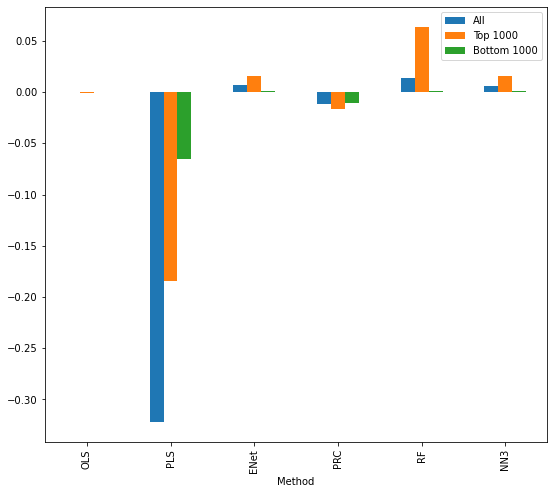

In [18]:
# plot
# R^2
data=[["OLS",0.0004615506976559658, -0.0006233830521982231, 0.0001384481657966674],
      ["PLS",-0.3222699287971331, -0.18402559781256977, -0.06527702248549994],
      ["ENet",0.007048221625425732, 0.015864294125976675, 0.0015854163446031855],
      ["PRC",-0.01141567540435684,-0.01645953127907429,  -0.01096673311725227],
      ["RF", 0.013953737330799298, 0.06377460807100477, 0.001364598780019155],
      ["NN3",0.006546128970214116, 0.01626982319065895, 0.0015747429988016703],
     ]

df_r2=pd.DataFrame(data, columns=["Method","All","Top 1000","Bottom 1000"])
df_r2.plot(x="Method", y=["All", "Top 1000", "Bottom 1000"], kind="bar",figsize=(9,8))
plt.show()

<AxesSubplot:title={'center':'PCR Variable importance'}>

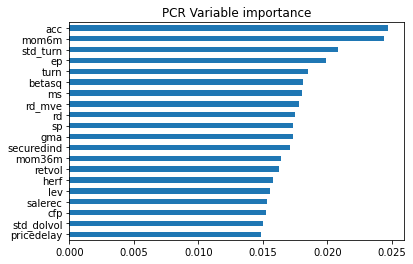

In [19]:
# Variable importance
VI = np.array([ 0.01110593,  0.00518593,  0.0181298,   0.01422532, -0.01955566,  0.00961722,
  0.01108318,  0.01239232,  0.02442281,  0.00946928,  0.01642417,  0.01482279,
  0.01850313,  0.01063863,  0.02473038, -0.00158947,  0.01192005, -0.06789517,
  0.00274609,  0.01525207,  0.00630838,  0.01194793,  0.00972743,  0.01275627,
  0.01174745,  0.00915017,  0.01456557,  0.01002587,  0.01281906,  0.01271731,
  0.01191914,  0.01306566,  0.01154413,  0.01987955,  0.01731725,  0.01209101,
  0.01356524,  0.01574894,  0.01242097,  0.01439628,  0.01554482,  0.00922852,
  0.01393293,  0.00840721,  0.00513376,  0.01193757,  0.01272904,  0.01283806,
  0.00683352,  0.01335431,  0.01179392,  0.01331287,  0.01313501,  0.01137796,
  0.00836877,  0.00267727,  0.01095155,  0.01748916,  0.01784  ,   0.01122647,
  0.00452065,  0.00178379,  0.0141171 ,  0.01398625,  0.01534175,  0.00815527,
  0.0170712,   0.01444716,  0.01187266,  0.01737652, -0.00418409,  0.01200473,
  0.01123758,  0.00811802,  0.01163235,  0.01422039,  0.0046616 ,  0.00816071,
 -0.00338184,  0.00693551,  0.00204712,  0.01400947,  0.01372818,  0.01293876,
  0.01801153,  0.01375025,  0.01211667,  0.01089008,  0.01628361,  0.01501566,
  0.02079846,  0.01405925,  0.01265276,  0.01216573])

order = VI.argsort()[::-1]
VI = VI[order]
header_cht_order = []
for i in range(len(order)):
  header_cht_order.append(header_cht[order[i]])

value = VI[0:20].copy()
value = value[::-1]
h = header_cht_order[0:20][::-1]
data= pd.Series(value,index=h)
data.plot.barh(title='PCR Variable importance')